### CAPSTONE Project: Atmospheric Physics using AI (ClimSim)
## Samanyu Parvathaneni

## Abstract
Climate models are crucial for understanding Earth's climate system. Due to the complexity of Earth's climate, these models use parameterizations to approximate the effects of physical processes that occur at scales smaller than the size of their grid cells. These approximations, however, are imperfect and contribute significantly to uncertainties in predicted warming, changing precipitation patterns, and the frequency and severity of extreme events. The Multi-scale Modeling Framework (MMF) approach, however, represents these subgrid processes more explicitly but at a computational cost too high for operational climate prediction.

This project aims to develop machine learning (ML) models that emulate subgrid atmospheric processes—such as storms, clouds, turbulence, rainfall, and radiation—within E3SM-MMF, a multi-scale climate model supported by the U.S. Department of Energy. ML emulators are significantly cheaper to run than MMF, and advancements in this area could enable high-resolution, physically credible long-term climate projections to become broadly accessible. This would enhance our understanding of climate-related hazards and empower policymakers with the knowledge needed to mitigate them.

## Research Question

Motivation: With the increasing frequency and severity of climate disasters, governments and other institutions are investing more time and money into projects that will be able to predict these catastrophies. We aim to model these weather events and figue out what features are the most predictive of natural disasters.

Research Question: What relationships can we find between observable weather data and climate events?

## Hypothesis

We believe that there will be many highly correlated variables, particularly the ones with the same number of dimensions.

## Data Preparation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dask as dd
import polars as pl
import ray
import gc  # Garbage Collector interface
import random
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-12-30 22:30:26,539	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-30 22:30:28.935432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 22:30:28.935579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 22:30:29.134334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/test_old.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission_old.csv


In [2]:
train_df = pl.read_csv('../input/leap-atmospheric-physics-ai-climsim/train.csv', n_rows = 100000).to_pandas()
test_df = pl.read_csv('../input/leap-atmospheric-physics-ai-climsim/test.csv', n_rows = 100000).to_pandas()
df_submission = pl.read_csv('../input/leap-atmospheric-physics-ai-climsim/sample_submission_old.csv', n_rows=100000).to_pandas()

In [3]:
# targets (extract from submission file)
targets = [x for x in df_submission.columns.tolist() if x not in ['sample_id']]

# numerical features
features_numerical = [x for x in train_df.columns.tolist() if x not in ['sample_id']+targets]

# categorical features
features_categorical = []

# all features combined
features_all = features_numerical + features_categorical

## Model Training

#### Neural Network (Keras) with ReLU activation, batch normalization, and dropout

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Assume train_df and test_df are already loaded with the specified columns

# Separate features and targets
feature_columns = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8','state_t_9', 
                   'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 
                   'state_t_20','state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 
                   'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39',
                   'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 
                   'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58','state_v_59', 
                   'state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8','state_q0001_9', 
                   'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 
                   'state_q0001_20','state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 
                   'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39',
                   'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 
                   'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58','state_v_59',
                   'state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8','state_q0002_9', 
                   'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 
                   'state_q0002_20','state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 
                   'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39',
                   'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 
                   'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58','state_v_59',
                   'state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8','state_q0003_9', 
                   'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 
                   'state_q0003_20','state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 
                   'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39',
                   'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 
                   'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58','state_v_59',
                   'state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8','state_u_9', 
                   'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 
                   'state_u_20','state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 
                   'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39',
                   'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 
                   'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58','state_v_59',
                   'state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8','state_v_9', 
                   'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 
                   'state_v_20','state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 
                   'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39',
                   'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 
                   'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58','state_v_59',
                   'state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ASDIF', 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHLAND',
                   'pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8','pbuf_ozone_9', 
                   'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 
                   'pbuf_ozone_20','pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 
                   'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39',
                   'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 
                   'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58','pbuf_ozone_59',
                   'pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8','pbuf_CH4_9', 
                   'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 
                   'pbuf_CH4_20','pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 
                   'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39',
                   'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 
                   'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58','pbuf_CH4_59',
                   'pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8','pbuf_N2O_9', 
                   'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 
                   'pbuf_N2O_20','pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 
                   'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39',
                   'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 
                   'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58','pbuf_N2O_59']

target_columns = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8','ptend_t_9', 
                   'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 
                   'ptend_t_20','ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 
                   'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39',
                   'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 
                   'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58','ptend_t_59',
                  'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8','ptend_q0001_9', 
                   'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 
                   'ptend_q0001_20','ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 
                   'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39',
                   'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 
                   'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58','ptend_q0001_59',
                  'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8','ptend_q0002_9', 
                   'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 
                   'ptend_q0002_20','ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 
                   'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39',
                   'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 
                   'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58','ptend_q0002_59',
                  'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8','ptend_q0003_9', 
                   'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 
                   'ptend_q0003_20','ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 
                   'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39',
                   'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 
                   'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58','ptend_q0003_59',
                  'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8','ptend_u_9', 
                   'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 
                   'ptend_u_20','ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 
                   'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39',
                   'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 
                   'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58','ptend_u_59',
                  'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8','ptend_v_9', 
                   'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 
                   'ptend_v_20','ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 
                   'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39',
                   'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 
                   'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58','ptend_v_59',
                  'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']

X_train = train_df[feature_columns][:70000]
y_train = train_df[target_columns][:70000]
X_test = train_df[feature_columns][70001:]
y_test = train_df[target_columns][70001:]

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [6]:
# Define the model
def build_model(input_shape, output_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_shape, activation='linear')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Build the model
model = build_model(X_train_scaled.shape[1], y_train_scaled.shape[1])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Custom R2 score callback
class R2ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.validation_data[0])
        val_true = self.validation_data[1]
        r2 = r2_score(val_true, val_pred)
        print(f" - val_r2: {r2:.4f}")
        logs['val_r2'] = r2

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=40,
    batch_size=2048,
    callbacks=[early_stopping, R2ScoreCallback((X_test_scaled, y_test_scaled))],
    verbose=1
)

# Save the trained model
model.save('/path/to/best_model_dataframe.h5')

Epoch 1/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
 - val_r2: -3641303699867803260724733534011392.0000
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - loss: 1.5838 - mse: 1.4979 - val_loss: 1.1222 - val_mse: 1.0399 - val_r2: -3641303699867803260724733534011392.0000
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
 - val_r2: -905497039778311247892433684398080.0000
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 1.0804 - mse: 0.9994 - val_loss: 0.8042 - val_mse: 0.7275 - val_r2: -905497039778311247892433684398080.0000
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
 - val_r2: -252579795697820700879864589189120.0000
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.8859 - mse: 0.8106 - val_loss: 0.7138 - val_mse: 0.6427 - val_r2: -252579795697820700879864589189120.0000
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
 - val_r2: -99658370556494960456382405410816.0000
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 0.8622 - mse: 0.7924 - val_loss: 0.6936 - val_mse: 0.6279 - val_r2:

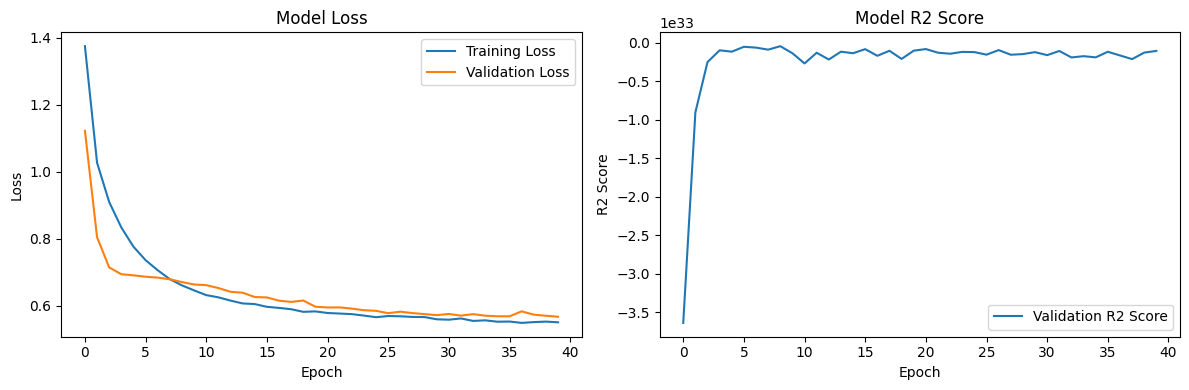

In [7]:
# Plotting learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_r2'], label='Validation R2 Score')
plt.title('Model R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Evaluate the model on the test set
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate the model on the test set
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate R2 score for the test set
test_r2 = r2_score(y_test, y_pred)
print(f"Test R2 Score: {test_r2:.4f}")

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4978 - mse: 0.4721
Test Loss: 0.5132
Test MSE: 0.4876
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4978 - mse: 0.4721
Test Loss: 0.5132
Test MSE: 0.4876
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test R2 Score: -2186265622.7375


#### XGBoost

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from statistics import mean
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

train_df = pl.scan_csv(f'/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv')
fetch_size =1000
input_columns = train_df.columns[1:557]
output_columns = train_df.columns[557:]
X = train_df.select(pl.col(input_columns)).fetch(fetch_size)
Y = train_df.select(pl.col(output_columns)).fetch(fetch_size)
big = train_df.select(pl.col("*")).fetch(fetch_size)

In [17]:
def adicionar_agua_v_erro_info(big: pl.DataFrame, margen = 0.00005) ->pl.DataFrame:
    gravidade = 9.80665
    ptend_vapor = big.select(pl.col("^ptend_q0001.*$")).to_numpy()
    ptend_liquido = big.select(pl.col("^ptend_q0002.*$")).to_numpy()
    ptend_gelo = big.select(pl.col("^ptend_q0003.*$")).to_numpy()
    
    state_vapor = big.select(pl.col("^state_q0001.*$")).to_numpy()
    state_liquido = big.select(pl.col("^state_q0002.*$")).to_numpy()
    state_gelo = big.select(pl.col("^state_q0003.*$")).to_numpy()
    
    precipitacao_agua = big.select(pl.col("^cam_out_PRECC.*$")).to_numpy().flatten()
    precipitacao_neve = big.select(pl.col("^cam_out_PRECSC.*$")).to_numpy().flatten()
    
    
    pressao = big.select(pl.col("^state_ps.*$")).to_numpy().flatten()
    volume_inicial = np.sum(state_vapor + state_liquido + state_gelo,axis=1)*(pressao/gravidade)
    volume_predito = np.sum(ptend_vapor + ptend_liquido + ptend_gelo,axis=1)*(pressao/gravidade) + precipitacao_agua + precipitacao_neve
    
    
    erro_volumetrico = abs((volume_predito - volume_inicial)/volume_inicial +1)
    flag_erro_volumetrico = (erro_volumetrico >margen).astype(np.int8)
    big = big.with_columns([
        pl.Series("erro_volumetrico",erro_volumetrico),
        pl.Series("flag_erro_volumetrico",flag_erro_volumetrico)
    ])
    return big

In [18]:
def custom_log_transform(column):
    """Applies a log1p transformation to a given column with an adjustment for negative values."""
    min_value = column.min()
    transformed_column = np.log1p(column - min_value + 1)  # log1p is log(1 + x) which is stable for small x
    return transformed_column

def log_transformation(data):
    """Applies custom log transformation to each column in the data."""
    data_log_transformed = np.array(data, dtype="float64")
    for i in range(data.shape[1]):
        data_log_transformed[:, i] = custom_log_transform(data[:, i])
    return data_log_transformed

def preprocess_data(X, Y, transform=True, log=False):
    """Preprocesses the data by scaling and optionally applying log transformation."""
    X_np = X.to_numpy()
    Y_np = Y.to_numpy()

    if transform:
        # Standardize features
        X_scaler = StandardScaler().fit(X_np)
        Y_scaler = StandardScaler().fit(Y_np)

        X_transformed = X_scaler.transform(X_np)
        Y_transformed = Y_scaler.transform(Y_np)

        if log:
            X_transformed = log_transformation(X_transformed)
            Y_transformed = log_transformation(Y_transformed)
        
        # Clean up
        del X, Y, X_np, Y_np

    else:
        # Split data into training and validation sets without transformation
        #X_train, X_val, Y_train, Y_val = train_test_split(X_np, Y_np, test_size=0.2, random_state=42)
        
        # Clean up
        del X, Y, X_np, Y_np

    return X_transformed, Y_transformed

# Example usage
# Assuming X and Y are defined and are Polars DataFrames
X_process, Y_process = preprocess_data(X, Y, transform=True, log=False)
X_train, X_val, Y_train, Y_val = train_test_split(X_process, Y_process, test_size=0.2, random_state=42)

In [19]:
big=adicionar_agua_v_erro_info(big)

{'whiskers': [<matplotlib.lines.Line2D at 0x7dc1c2beaf50>,
 'caps': [<matplotlib.lines.Line2D at 0x7dbfe11103d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7dbfe101a920>],
 'medians': [<matplotlib.lines.Line2D at 0x7dbfe11106d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7dbfe1110be0>],
 'means': []}

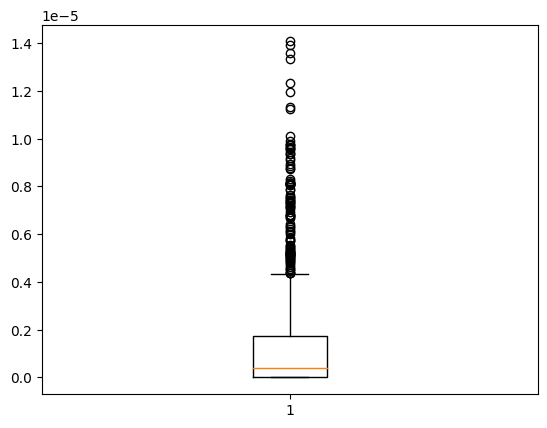

In [20]:
plt.boxplot(big["erro_volumetrico"])


In [21]:
sum(big["flag_erro_volumetrico"]>0)

0

{'whiskers': [<matplotlib.lines.Line2D at 0x7dc1109969b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7dc110996ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7dc110996710>],
 'medians': [<matplotlib.lines.Line2D at 0x7dc110997430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7dc1109976d0>],
 'means': []}

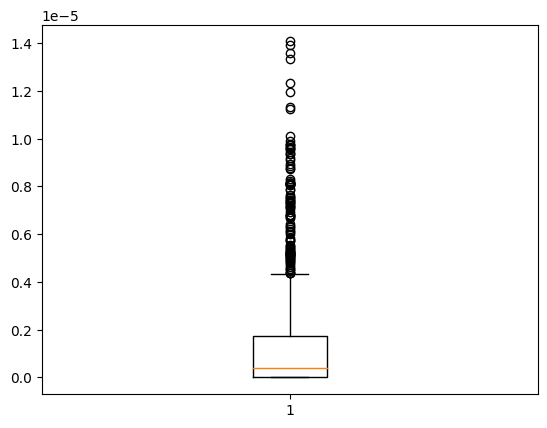

In [22]:
plt.boxplot(big["erro_volumetrico"])

In [23]:
# Initialize model
model = XGBRegressor(
    n_estimators= 1150,
    max_depth=56,
    learning_rate=0.003,
    colsample_bytree=0.9,
    subsample=0.8,
    min_child_weight=1,
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1,  # Use all available cores
    tree_method='hist',
    device ='cuda',
)

r2_vector = []
mse_vector = []

y_pred_df = pd.DataFrame()
out_i =360
out_f=361
for i in range(out_i, out_f):
    
    model.fit(X_train, Y_train[:, i]) 
    y_pred = model.predict(X_val)
    y_pred_df[f'y_pred_{i}'] = y_pred
    
    # Calculate r
    r2 = r2_score(Y_val[:, i], y_pred)
    mse = mean_squared_error(Y_val[:, i], y_pred)
    print(f"{r2},{mse}")
    # Append scores to the lists
    r2_vector.append(r2)
    mse_vector.append(mse)

# Optionally convert lists to DataFrame for r2 and mse scores
r2_df = pd.DataFrame({'r2_score': r2_vector})
mse_df = pd.DataFrame({'mse_score': mse_vector})

# Now y_pred_df contains all the predictions for each target variable

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:45:24] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.9655256452963115,0.03215382650786335


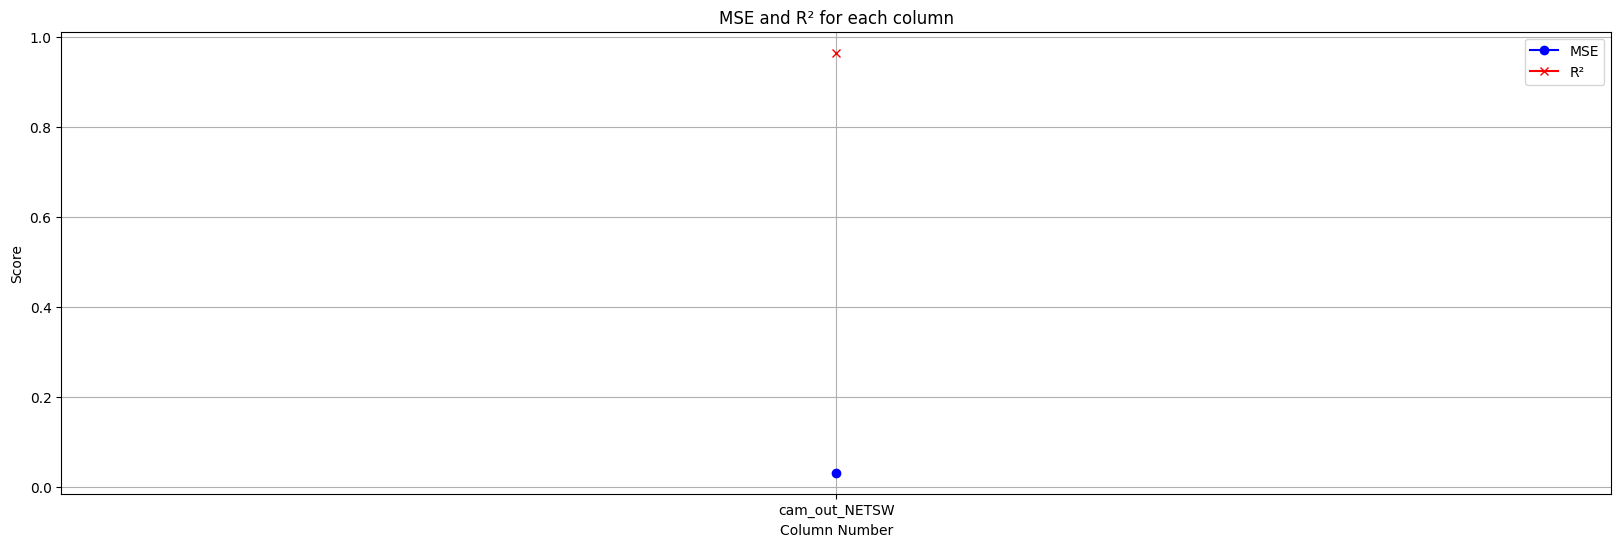

In [24]:
columns = output_columns[out_i:out_f]
plt.figure(figsize=(20, 6))
plt.plot(columns, mse_vector, label='MSE', color='blue', marker='o')
plt.plot(columns, r2_vector, label='R²', color='red', marker='x')

plt.xlabel('Column Number')
plt.ylabel('Score')
plt.title('MSE and R² for each column')
plt.legend()
plt.grid(True)
plt.show()

#### Multi-Layer Perceptron

In [25]:
leap_raw_df = pl.scan_csv(f'/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv')
fetch_size =100000
input_columns = leap_raw_df.columns[1:557]
output_columns = leap_raw_df.columns[557:]

X = leap_raw_df.select(pl.col(input_columns)).fetch(fetch_size)
Y = leap_raw_df.select(pl.col(output_columns)).fetch(fetch_size)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
constant_epson = 1
constant_epson_r = 1
def log_transform(x):
    return (np.log1p(x+constant_epson) +constant_epson_r)

# Convert Polars DataFrame to NumPy array
X_np = X.to_numpy()
Y_np = Y.to_numpy()

transformer_X = StandardScaler().fit(X_np)
transformer_Y = StandardScaler().fit(Y_np)

X_transformed = transformer_X.transform(X_np)
Y_transformed = transformer_Y.transform(Y_np)



# Log
#transformer =FunctionTransformer(log_transform)
#X_transformado=transformer.transform(X_np)
#Y_transformado=transformer.transform(Y_np)

In [27]:
print(X_transformed.dtype)
print(Y_transformed.dtype)

float64
float64


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

X_tensor = torch.tensor(X_transformed, dtype=torch.float64)
Y_tensor = torch.tensor(Y_transformed, dtype=torch.float64)

In [29]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [30]:
X_train, X_val, Y_train,Y_val = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

def create_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [32]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import polars as pl

def objective(trial):
    # Define the actual input size and output size based on your data
    input_size = 556  # Number of features in X
    output_size = 368  # Number of targets in Y

    # Tune the number of hidden layers and units per layer
    hidden_layers = trial.suggest_int('hidden_layers', 3, 8)
    hidden_units = trial.suggest_int('hidden_units', 512, 1024)
    batch_size = trial.suggest_int('batch_size', 1536, 4608)
    learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float64)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float64)

    # Define the architecture of the MLP
    class MLPRegressor(nn.Module):
        def __init__(self, input_size, output_size, hidden_layers, hidden_units):
            super(MLPRegressor, self).__init__()
            layers = []
            layers.append(nn.Linear(input_size, hidden_units, dtype=torch.float64))
            layers.append(nn.LeakyReLU(0.15))
            for _ in range(hidden_layers - 1):
                layers.append(nn.Linear(hidden_units, hidden_units, dtype=torch.float64))
                layers.append(nn.LeakyReLU(0.15))
            layers.append(nn.Linear(hidden_units, output_size, dtype=torch.float64))
            self.model = nn.Sequential(*layers)
        
        def forward(self, x):
            return self.model(x)

    model = MLPRegressor(input_size, output_size, hidden_layers, hidden_units).double()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def create_dataloader(X, Y, batch_size):
        dataset = torch.utils.data.TensorDataset(X, Y)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_loader = create_dataloader(X_train_tensor, Y_train_tensor, batch_size)
    val_loader = create_dataloader(X_val_tensor, Y_val_tensor, batch_size)

    # Train the model
    def train(model, criterion, optimizer, train_loader, val_loader, epochs=4):
        model.train()
        for epoch in range(epochs):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        # Evaluate on the validation set
        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for val_inputs, val_targets_batch in val_loader:
                val_outputs = model(val_inputs)
                val_preds.append(val_outputs)
                val_targets.append(val_targets_batch)
        
        val_preds = torch.cat(val_preds).cpu().numpy()
        val_targets = torch.cat(val_targets).cpu().numpy()
        val_preds[:, 61] = 0
        mse = mean_squared_error(val_targets, val_preds)
        
        r2_values = []
        for i in range(output_size):
            r2 = r2_score(val_targets[:, i], val_preds[:, i])
            r2_values.append(r2)
        print(f"R² for column 62: {r2_values[61]}")

        # Calculate the average R² excluding the value at index 61
        r2_values_excluding_61 = [r2 for idx, r2 in enumerate(r2_values) if idx != 61]
        avg_r2_excluding_61 = sum(r2_values_excluding_61) / len(r2_values_excluding_61)
        print("Average R² excluding column 61:", avg_r2_excluding_61)
        return avg_r2_excluding_61

    avg_r2_excluding_61 = train(model, criterion, optimizer, train_loader, val_loader)
    return avg_r2_excluding_61

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

print("Best hyperparameters: ", study.best_params)
print("Best value (MSE): ", study.best_value)

[I 2024-12-30 23:14:42,679] A new study created in memory with name: no-name-1af18056-7277-497d-af65-75be7fd5e94a
/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dt

R² for column 62: -0.0001582125814720836
Average R² excluding column 61: -3.422372073367912e+45


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -1.204546667486323e+37


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -2.376199773091267e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.0001582125814720836
Average R² excluding column 61: -1.8348119606206665e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.0001582125814720836
Average R² excluding column 61: -1.864788607194966e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147186157
Average R² excluding column 61: -1.4667241427036644e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -2.367685624860981e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -1.6822738951320458e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -5.025265591828474e+45


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147163952
Average R² excluding column 61: -1.6218112197733546e+38


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.0001582125814720836
Average R² excluding column 61: -2.8463884111870523e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -1.4004718572481394e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -2.7548618584764444e+31


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.0001582125814720836
Average R² excluding column 61: -2.38883520730873e+40


/tmp/ipykernel_33/1142237259.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2.5e-4, 2.5e-2)
/tmp/ipykernel_33/1142237259.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train, dtype=torch.float64)
/tmp/ipykernel_33/1142237259.py:22: UserWarning: To copy construct from a tensor, it is recomme

R² for column 62: -0.00015821258147230566
Average R² excluding column 61: -1.1180549266502544e+31
Best hyperparameters:  {'hidden_layers': 6, 'hidden_units': 803, 'batch_size': 2254, 'learning_rate': 0.0008367957375003527}
Best value (MSE):  -1.1180549266502544e+31


In [33]:
import optuna
import warnings
warnings.filterwarnings("ignore")

In [34]:
import optuna.visualization as vis
import matplotlib.pyplot as plt

In [35]:
importance_plot = vis.plot_param_importances(study)
importance_plot.show()

In [36]:
opt_history_plot = vis.plot_optimization_history(study)
opt_history_plot.show()

In [37]:
parallel_plot = vis.plot_parallel_coordinate(study)
parallel_plot.show()

In [38]:
contour_plot = vis.plot_contour(study)
contour_plot.show()